<a href="https://colab.research.google.com/github/battistabiggio/ai4dev/blob/main/notebooks/neural-networks-with-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks with PyTorch

This notebook provides a brief introduction to PyTorch, inspired from the PyTorch tutorials available at https://github.com/yunjey/pytorch-tutorial and https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

Let's start with tensors, autograd/autodiff and to/from numpy conversions.

In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


# ================================================================== #
#                        Basic autograd example                      #
# ================================================================== #

# Create tensors.
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2
print(w.grad)    # w.grad = 1
print(b.grad)    # b.grad = 1


# ================================================================== #
#                        Loading data from numpy                     #
# ================================================================== #

# Create a numpy array.
x = np.array([[1, 2], [3, 4]])

# Convert the numpy array to a torch tensor.
y = torch.from_numpy(x)

# Convert the torch tensor to a numpy array.
z = y.numpy()

print("x: ", x)
print("y: ", y)
print("z: ", z)

tensor(2.)
tensor(1.)
tensor(1.)
x:  [[1 2]
 [3 4]]
y:  tensor([[1, 2],
        [3, 4]])
z:  [[1 2]
 [3 4]]


## Logistic/Softmax Classifier on MNIST data

We aim to learn a multiclass linear classifier $f(x) = Wx+b$ on the MNIST dataset, where we have $d=28 \times 28=784$ pixels as inputs, and we aim to predict $k=10$ values (one output per class), i.e., $f(x) : R^d \mapsto R^k$.

To learn the classifier parameters $W \in R^{k \times d}, b \in R^k$, we minimize the cross-entropy loss on the softmax-scaled $k$ outputs:

$$\min_{W,b} L(\mathcal D, W, b) = -\sum_{i=1}^{n} \sum_{c=1}^{k} y_{i c} \cdot \log \left( \sigma(f_{c}(x_i; W, b))\right),$$

where $\mathcal D = (x_i, y_i)_{i=1}^n$ is the training set, $\sigma$ is the softmax operator, and $y_{ic}$ is 1 if the training sample $x_i$ belongs to class $c$ and 0 otherwise (one-hot label encoding of $y_i$).

More details (including gradient computation) at: https://peterroelants.github.io/posts/cross-entropy-softmax/.


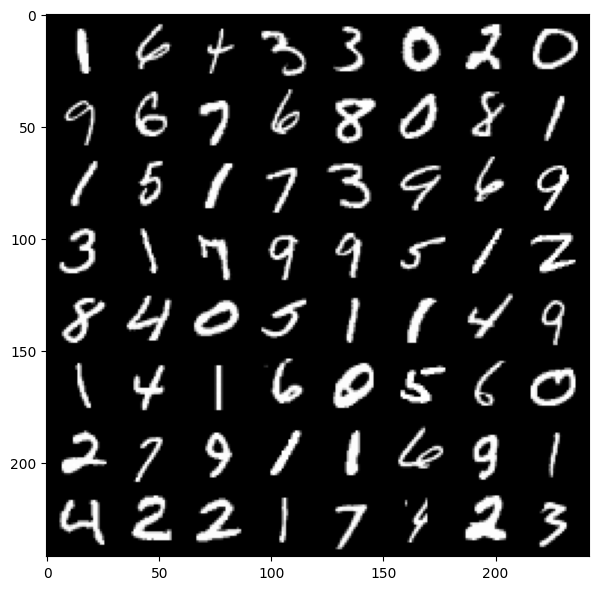

In [4]:
# Hyper-parameters
input_size = 28 * 28    # 784
num_classes = 10
batch_size = 64

# set CPU or GPU, if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(7,10))
imshow(torchvision.utils.make_grid(images, nrow=8))



In [5]:
# Hyper-parameters
num_epochs = 2
learning_rate = 0.001

# Logistic regression model
model = nn.Linear(input_size, num_classes).to(device)

# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
loss_path = np.zeros(shape=(num_epochs,total_step))
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss_path[epoch][i] = loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))



Epoch [1/2], Step [100/938], Loss: 2.2031
Epoch [1/2], Step [200/938], Loss: 2.1055
Epoch [1/2], Step [300/938], Loss: 1.9879
Epoch [1/2], Step [400/938], Loss: 1.9005
Epoch [1/2], Step [500/938], Loss: 1.8250
Epoch [1/2], Step [600/938], Loss: 1.7471
Epoch [1/2], Step [700/938], Loss: 1.6544
Epoch [1/2], Step [800/938], Loss: 1.6102
Epoch [1/2], Step [900/938], Loss: 1.5218
Epoch [2/2], Step [100/938], Loss: 1.5028
Epoch [2/2], Step [200/938], Loss: 1.4132
Epoch [2/2], Step [300/938], Loss: 1.3738
Epoch [2/2], Step [400/938], Loss: 1.2927
Epoch [2/2], Step [500/938], Loss: 1.3070
Epoch [2/2], Step [600/938], Loss: 1.3334
Epoch [2/2], Step [700/938], Loss: 1.2357
Epoch [2/2], Step [800/938], Loss: 1.2472
Epoch [2/2], Step [900/938], Loss: 1.2408


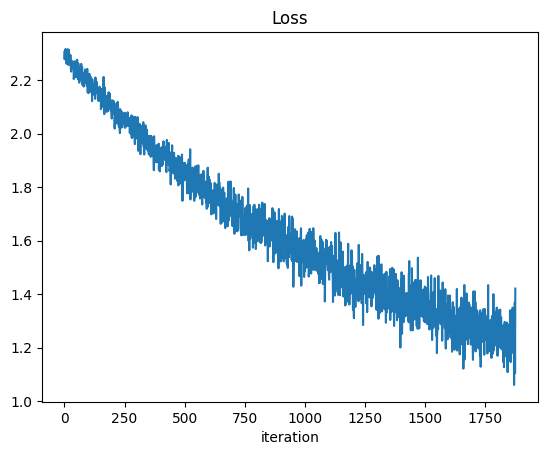

In [6]:
plt.figure()
plt.plot(loss_path.ravel())
plt.title('Loss')
plt.xlabel("iteration")
plt.show()

In [7]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'
          .format(100.0 * correct / total))

Accuracy of the model on the 10000 test images: 80.58000183105469 %


## Training a CNN on MNIST

In [8]:
# Hyper-parameters
num_epochs = 2
learning_rate = 0.001

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
loss_path = np.zeros(shape=(num_epochs,total_step))
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss_path[epoch][i] = loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/2], Step [100/938], Loss: 0.0998
Epoch [1/2], Step [200/938], Loss: 0.0501
Epoch [1/2], Step [300/938], Loss: 0.1233
Epoch [1/2], Step [400/938], Loss: 0.1004
Epoch [1/2], Step [500/938], Loss: 0.0126
Epoch [1/2], Step [600/938], Loss: 0.1403
Epoch [1/2], Step [700/938], Loss: 0.0136
Epoch [1/2], Step [800/938], Loss: 0.0597
Epoch [1/2], Step [900/938], Loss: 0.0225
Epoch [2/2], Step [100/938], Loss: 0.0134
Epoch [2/2], Step [200/938], Loss: 0.0591
Epoch [2/2], Step [300/938], Loss: 0.0095
Epoch [2/2], Step [400/938], Loss: 0.0121
Epoch [2/2], Step [500/938], Loss: 0.0042
Epoch [2/2], Step [600/938], Loss: 0.1230
Epoch [2/2], Step [700/938], Loss: 0.0376
Epoch [2/2], Step [800/938], Loss: 0.0077
Epoch [2/2], Step [900/938], Loss: 0.1226


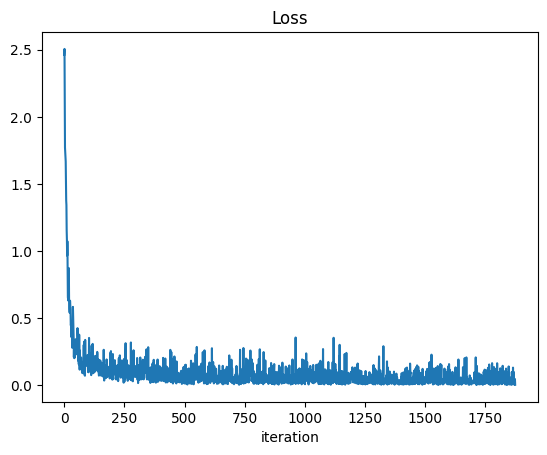

In [9]:
plt.figure()
plt.plot(loss_path.ravel())
plt.title('Loss')
plt.xlabel("iteration")
plt.show()

In [10]:
# Test the model
# eval mode (batchnorm uses moving mean/var instead of mini-batch mean/var)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'
          .format(100.0 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.8 %


## Training a CNN on CIFAR10

Source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Files already downloaded and verified
Files already downloaded and verified
 frog  deer  bird truck   car horse  bird   car


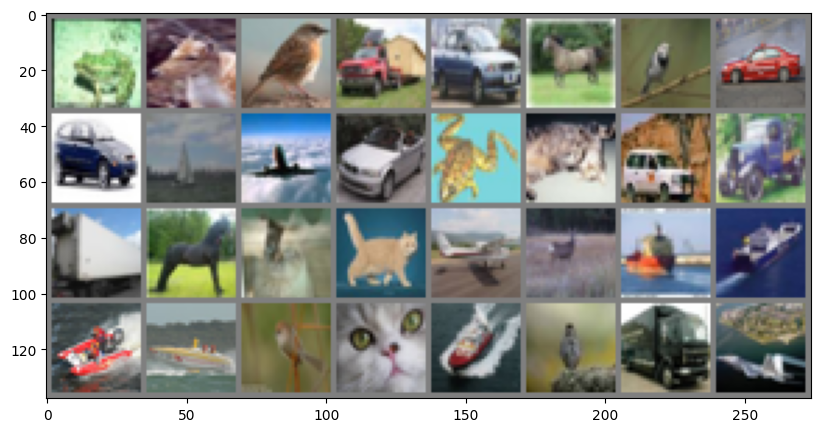

In [18]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print labels for the first 8 images
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

# show images
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))

In [19]:
import torch.nn.functional as F

# Conv2d: https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html
# MaxPool2d: https://pytorch.org/docs/master/generated/torch.nn.MaxPool2d.html
# These layers rescale inputs as described in the docs
# In our case below, we do not use dilation and padding is zero,
# hence we can compute h_out and w_out as:
# h_out = floor( (h_in - kernel_size)/stride +1 )

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # input size after conv1 is: 28x28x6
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # input size after pool is: 14x14x6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # input size after conv2 is: 10x10x16
        # input size after conv2 and pool is: 5x5x16
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.303
[1,   200] loss: 2.283
[1,   300] loss: 2.303
[1,   400] loss: 2.295
[1,   500] loss: 2.277
[1,   600] loss: 2.278
[1,   700] loss: 2.252
[1,   800] loss: 2.204
[1,   900] loss: 2.159
[1,  1000] loss: 1.976
[1,  1100] loss: 1.967
[1,  1200] loss: 2.284
[1,  1300] loss: 2.174
[1,  1400] loss: 2.010
[1,  1500] loss: 2.093
[2,   100] loss: 2.003
[2,   200] loss: 1.814
[2,   300] loss: 1.989
[2,   400] loss: 1.811
[2,   500] loss: 1.893
[2,   600] loss: 1.624
[2,   700] loss: 1.935
[2,   800] loss: 1.728
[2,   900] loss: 1.869
[2,  1000] loss: 1.687
[2,  1100] loss: 1.687
[2,  1200] loss: 1.595
[2,  1300] loss: 1.825
[2,  1400] loss: 1.478
[2,  1500] loss: 1.586
Finished Training


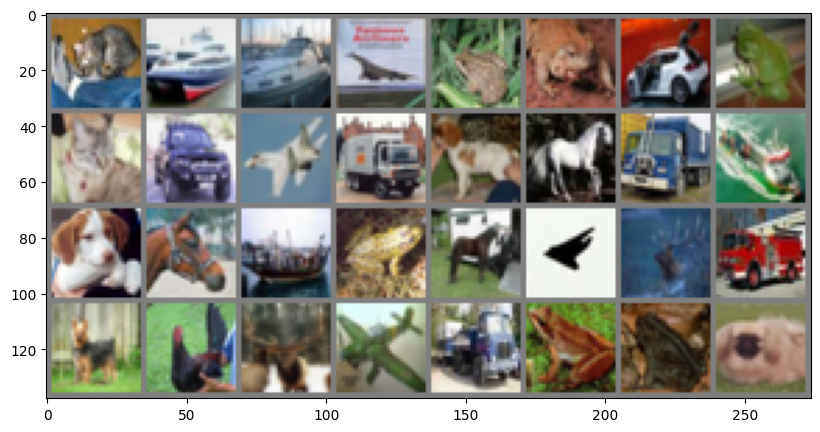

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# per-class accuracies
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 40 %
Accuracy of plane : 55 %
Accuracy of   car : 66 %
Accuracy of  bird :  5 %
Accuracy of   cat : 10 %
Accuracy of  deer : 10 %
Accuracy of   dog : 50 %
Accuracy of  frog : 66 %
Accuracy of horse : 52 %
Accuracy of  ship : 33 %
Accuracy of truck : 57 %
